In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 60

In [3]:
#utils.py is where all our custorm functions live is we set an autoreload on it.
%aimport utils 
from utils import *

# The data

In [4]:
df_all = pd.read_excel('all data v3.xlsx', 'iLab data.txt', index_col=None, na_values=['NA'])

### Preparing a test sample
Let's first use a particular session as a test case. We extract only the data relevant to that case

In [5]:
#Using the example used for sketch.
#(df_all.condition1 == 'Savanna') & (df_all.student1 == 'penguin') & (df_all.student2 == 'gorilla')]
df_test = df_all[df_all['Session Id'] == 'L-2567b17a:120eda25685:-8000']

Next we filter out all actions with "INCORRECT" outcomes

In [6]:
before = df_test.shape[0]
df_test = df_test[df_test['Outcome'] == 'CORRECT']
print "We are left with {0} rows out of {1}".format(df_test.shape[0],before)

We are left with 212 rows out of 285


We also clean up the methods removing annoying characters like "{"

In [7]:
df_test['Cleaned method 1'] = df_test[['Method_Recognized_1_Copied']].applymap(lambda method:clean_method(method))
df_test['Cleaned method 2'] = df_test[['Method_Recognized_2_Copied']].applymap(lambda method:clean_method(method))

We create a column with the data for the contrasting cases

In [8]:
df_test['cases'] = df_test['CF(new1)'].str.replace('"','') +','+ df_test['CF(new2)'].str.replace('"','')

### We need to extract the time stamp of each action and it's duration

Next we fix the time logs and convert them to seconds. We also recalculate the time between actions now that we have gotten rid of incorrect actions.

In [9]:
time_start = list(df_test['time first action'])[0]
df_test['Time_seconds'] = df_test[['Time']].applymap(lambda current_time: fix_time(time_start,current_time))
df_test['Timeshifted'] = df_test[['Time']].shift(-1)
df_test['Duration'] = df_test[['Time','Timeshifted']].apply(get_duration, axis=1)

# A first plot

In [10]:
colors = {"Now try working on this new example":"#252525",
         "intuition": "#bdbdbd",
         "submit": "#969696",
         "evaluation": "#737373",
         "checkIntuition": "#525252",
         'Median': "#33a02c",
         'Average': "#6a3d9a",
         'Sum': "#1f78b4",
         'all': "#ff7f00",
        }
column_to_use = {"Now try working on this new example":"Feedback Text",
                 "intuition": "Selection",
                 "submit": "Selection",
                 "evaluation": "Selection",
                 "checkIntuition": "Selection",
                 'Median': 'Cleaned method 1',
                 'Average': 'Cleaned method 1',
                 'Sum': 'Cleaned method 1',
                 'all': 'Cleaned method 1',
                }
function_to_use = {}
to_plot = ["intuition",'Median','Average','Sum','all',"submit","evaluation","checkIntuition"]

In [11]:
def plot(to_plot,colors, column_to_use, function_to_use):
    fig = plt.figure(figsize=(18,8))
    ax = plt.subplot()
    spacing =10
    pos = 0
    max_time = 0
    actions = list(reversed(to_plot))
    black = '#252525'
    for i,action in enumerate(actions):
        if action in column_to_use.keys():
            action_use = get_action_usage(df_test,column_to_use[action],action)
        else:
            action_use = function_to_use[action](df_test)
        if action_use:
            max_time = max(max_time,sum(action_use[-1]))
            ax.broken_barh(action_use,(pos,spacing),facecolors=colors[action],alpha=1,linewidth=0)
        pos += spacing

    #Add horizontal bar
    ax.broken_barh([(0,ax.get_xlim()[1])],((len(actions))*spacing,spacing),facecolors='white',alpha=1,linewidth=0)

    #Add new case bar
    new_case = "Now try working on this new example"
    action_use = get_action_usage(df_test,column_to_use[new_case],new_case)
    max_time = max(max_time,sum(action_use[-1]))
    ax.broken_barh(action_use,(0,(len(actions)+1)*spacing),facecolors=black,alpha=1,linewidth=0)

    ax.set_xlabel('minutes in activity')
    ax.set_xticks(range(0,int(max_time),60*5))
    ax.set_xticklabels([str(x/60)+'' for x in range(0,int(max_time),60*5)])
    ax.set_yticks(range(spacing/2,len(actions)*spacing,spacing))
    ax.set_yticklabels(actions)
    ax.grid(True)
    plt.show()

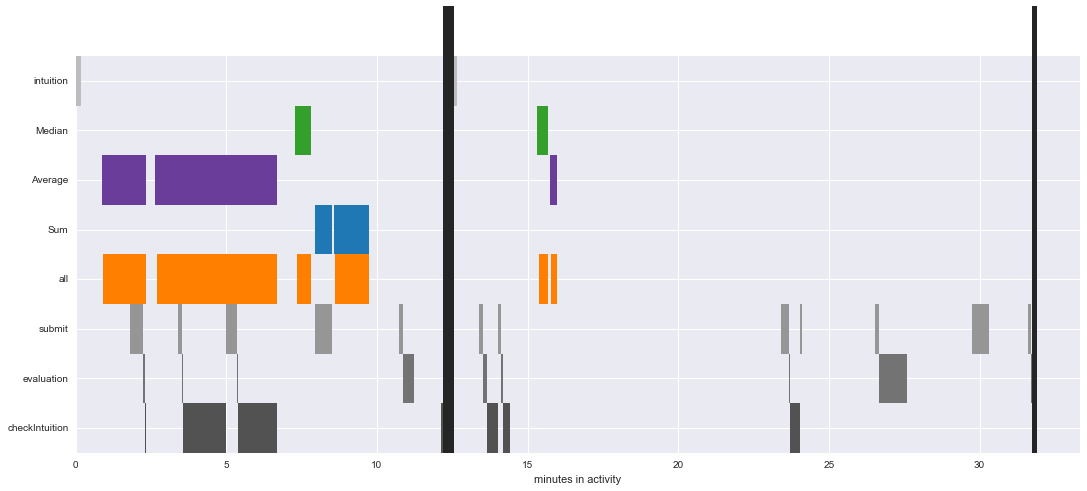

In [12]:
plot(to_plot,colors, column_to_use, function_to_use)

The black vertical bar in the graph shows when a "new case" is presented

# The actual plot we want

In [13]:
colors = {"Now try working on this new example":"#252525",
         "intuition": "#969696",
         "single value": "red",
         'Central tendency': "#33a02c",
#          'Median': "#33a02c",
#          'Average': "#6a3d9a",
#          'Sum': "#1f78b4",
          'range': "#1f78b4",
         'all': "#ff7f00",
         'evaluation steps': "#525252",
        }
column_to_use = {"Now try working on this new example":"Feedback Text",
                 "intuition": "Selection",
                 "submit": "Selection",
                 "evaluation": "Selection",
                 "checkIntuition": "Selection",
                 'Median': 'Cleaned method 1',
                 'Average': 'Cleaned method 1',
                 'Sum': 'Cleaned method 1',
                 'all': 'Cleaned method 1',
                }

function_to_use = {"single value":get_single_value_usage,
                   "Central tendency":get_central_tendency_usage,
                   "range":get_range_usage,
                   "evaluation steps":get_evaluation_steps_usage}

to_plot = ["intuition",'single value','Central tendency','range',"evaluation steps"]

utils.py:106: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return zip(df[df[column].str.match(action,as_indexer=True)]['Time_seconds'],df[df[column].str.match(action,as_indexer=True)]['Duration'])


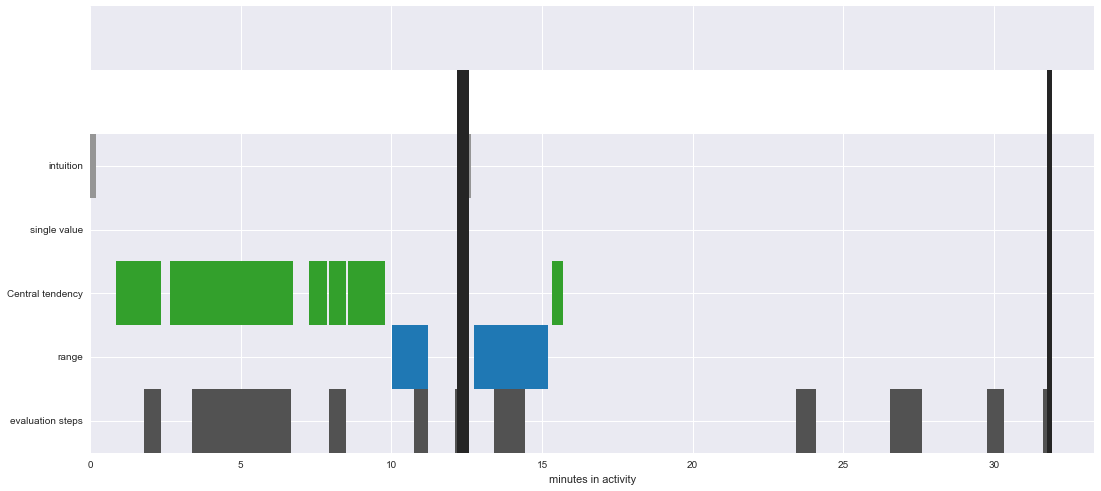

In [14]:
plot(to_plot,colors, column_to_use, function_to_use)

### TODO
Ordered in some kind of general priority (in terms of need of feedback and desired feature)
* start implementing categories that are under “option 4” in the coding document (see copy below from May 29th)
* display method at "max", after a submit or delete all/reset
* add case data to graph
* display method at "max", after a submit or delete all/reset
* merge evaluation and checkintuition
* Indicate when current method could be used to “crack” or solve the contrasting cases. (‘when it works’) => correct order. 

### Overall graph structure:
Row 1: intuition
Rows 2-n: methods
Plot “build” events (any click in that part of the interface).
Below, show the method in writing.
Row n+1: Submit
Row n+2: Evaluation (merge Evaluate, Check Intuition).
Later consider merging “submit” into this. 
 
Plot building events, not durations 
Pauses become gaps. 



#### Categories
1. single value -DONE
* Central tendency, ready made -DONE
* Combination of ready made, random
* Range 6 - 1
* Count gaps (if numbers are 1 4 4 6)
    * click all empty points within range - 2 3 5
    * click all empty points within the largest gap - 2 3
* Extrapolated range
    * Inner range 4-4 - single step method
    * Any method that uses more than extreme values, and some form of subtraction. 
        * Recursive range (6-1) +/- (4-4)
        * All pairwise ranges (6-1, 6-4, 4-4, 4-1)
* extrapolated range + count all
* Canonical
